In [1]:
!pip3 install git+https://github.com/holounic/Bayesian-Optimization.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/holounic/Bayesian-Optimization.git to /tmp/pip-req-build-p1o53sj2
  Running command git clone -q https://github.com/holounic/Bayesian-Optimization.git /tmp/pip-req-build-p1o53sj2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/holounic/pyDOE to /tmp/pip-install-pq4vrigy/pydoe_f99e653e6f90467f912e0f5a939acb3a
  Running command git clone -q https://github.com/holounic/pyDOE /tmp/pip-install-pq4vrigy/pydoe_f99e653e6f90467f912e0f5a939acb3a
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 316 kB 11.4 MB/s 
  Created wheel for bayes-optim: filename=bayes_optim-0.2.7-py3-none-any.whl size=145056 sha256=04b2005e67782b83e6b600317e8fe06a7f6f7051243ff7dca0fc0e651f030c19
  Stored in directory: /tmp/pip-ephem-wheel-cache-

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from benchmark.bbobbenchmarks import F9
from bayes_optim.search_space import RealSpace

In [3]:
dim = 2
lb, ub = -5, 5
space = RealSpace([lb, ub]) * dim
f_name = 'f9'
f = F9

samples = space.sample(50000)

In [4]:
def fix_numeric_data(df):
  regrets = [float(x[1:-1]) for x in df['regret'].tolist()]
  df['regret'] = regrets
  return df

In [5]:
def minmax_normalisation():
  minmax = []
  for i in range(50):
    func = f(i)
    minmax.append(func(samples).max() - func.getfopt())
  return minmax

In [6]:
def abs_normalisation():
  n = []
  for i in range(50):
    func = f(i)
    n.append(func(samples).mean() - func.getfopt())
  return n

In [8]:
cma_es = fix_numeric_data(pd.read_csv(f'{f_name}_cma_es_doe_normalized.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'cma_es_regret', 'min_dist_to_opt': 'dopt_cma'})
cma_es_init = fix_numeric_data(pd.read_csv(f'{f_name}_lhs_initial_doe_normalized.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'lhs_init_regret', 'min_dist_to_opt': 'dopt_init'})
uniform = fix_numeric_data(pd.read_csv(f'uniform_doe_{f_name}.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'uniform_regret', 'min_dist_to_opt': 'dopt_uni'})
lhs = fix_numeric_data(pd.read_csv(f'lhs_doe_{f_name}.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'lhs_regret', 'min_dist_to_opt': 'dopt_lhs'})
halton = fix_numeric_data(pd.read_csv(f'halton_doe_{f_name}.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'halton_regret', 'min_dist_to_opt': 'dopt_hal'})
sobol = fix_numeric_data(pd.read_csv(f'sobol_doe_{f_name}.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'sobol_regret', 'min_dist_to_opt': 'dopt_sob'})
stats = cma_es.merge(uniform.merge(lhs.merge(sobol.merge(halton.merge(cma_es_init)))))
stats['minmax_norm'] = minmax_normalisation()
stats['abs_norm'] = abs_normalisation()
stats.head()

,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
0,0.663671,0,0.340654,7.871626,3.480925,7.987268,1.980372,0.948432,1.042709,1.980730,2.784141,1.158260,2.802967,248450.739039,15274.126144
1,2.632773,1,0.434271,0.613708,1.931839,1.259330,1.326769,35.314736,2.787093,1.258125,2.417295,3.501588,2.661393,314108.533567,18113.488271
2,1.376448,2,0.988343,8.636624,1.769060,11.397823,2.285068,1.080733,1.091367,2.353210,1.991689,9.845075,1.954974,321776.528893,17614.477195
3,1.291830,3,0.693038,13.714469,1.307633,0.089657,2.690338,3.516776,2.397855,1.179184,2.597743,13.603137,2.537715,241429.123354,16455.438156
4,1.137312,4,0.333834,10.843660,1.251042,1.091171,2.850873,7.726755,1.125662,0.935026,0.640180,0.613578,2.832712,162275.563450,13892.973270


# CMA-ES vs first individual (generated by LHS)

In [9]:
cma_init = stats.loc[stats['cma_es_regret'] < stats['lhs_init_regret']]
print(f'CMA-ES improved lhs DoE on {cma_init.shape[0]}, ({100 * cma_init.shape[0] / stats.shape[0]}%) function instances')
cma_init[['f_s', 'cma_es_regret', 'lhs_init_regret', 'dopt_cma', 'dopt_init']]

CMA-ES improved lhs DoE on 26, (52.0%) function instances


,f_s,cma_es_regret,lhs_init_regret,dopt_cma,dopt_init
0,0,0.663671,1.158260,0.340654,2.802967
1,1,2.632773,3.501588,0.434271,2.661393
2,2,1.376448,9.845075,0.988343,1.954974
3,3,1.291830,13.603137,0.693038,2.537715
6,6,1.416331,5.806288,0.409309,2.896115
7,7,2.281067,3.188178,0.488672,2.748370
8,8,1.821276,2.777489,0.483265,2.559434
10,10,0.029826,2.246077,0.360088,2.805795
13,13,2.409652,6.896790,1.082609,2.393389
15,15,1.277202,5.563395,0.950109,2.692087


In [10]:
cma_init = stats.loc[stats['cma_es_regret'] > stats['lhs_init_regret']]
print(f'CMA-ES worstened lhs DoE on {cma_init.shape[0]}, ({100 * cma_init.shape[0] / stats.shape[0]}%) function instances')
cma_init[['f_s', 'cma_es_regret', 'lhs_init_regret', 'dopt_cma', 'dopt_init']]

CMA-ES worstened lhs DoE on 24, (48.0%) function instances


,f_s,cma_es_regret,lhs_init_regret,dopt_cma,dopt_init
4,4,1.137312,0.613578,0.333834,2.832712
5,5,1.209525,1.068427,0.913981,2.627646
9,9,2.214928,1.129575,0.737452,2.523669
11,11,8.083735,3.452043,1.030620,2.863939
12,12,1.115279,0.212665,0.332162,2.811885
14,14,13.894311,7.067577,0.363877,2.807368
17,17,9.091213,7.581802,0.804641,2.019450
18,18,18.491337,7.317862,0.429312,2.672246
19,19,8.116658,0.768788,1.029828,2.867139
20,20,0.555215,0.098796,1.031305,2.861148


# CMA-ES generated vs Uniform

In [11]:
cma_uniform = stats.loc[stats['cma_es_regret'] < stats['uniform_regret']]
print(f'DoE generated by CMA-ES is better than uniformly sampled DoE on {cma_uniform.shape[0]}, ({100 * cma_uniform.shape[0] / stats.shape[0]}%) function instances')
cma_uniform[['f_s', 'cma_es_regret', 'uniform_regret']]

DoE generated by CMA-ES is better than uniformly sampled DoE on 28, (56.0%) function instances


,f_s,cma_es_regret,uniform_regret
0,0,0.663671,7.871626
2,2,1.376448,8.636624
3,3,1.291830,13.714469
4,4,1.137312,10.843660
6,6,1.416331,1.713469
8,8,1.821276,1.898802
9,9,2.214928,2.608004
10,10,0.029826,0.940355
12,12,1.115279,2.305583
15,15,1.277202,2.242877


# CMA-ES vs LHS

In [12]:
cma_lhs = stats.loc[stats['cma_es_regret'] < stats['lhs_regret']]
print(f'DoE generated by CMA-ES is better than lhs sampled DoE on {cma_lhs.shape[0]} ({100 * cma_lhs.shape[0] / stats.shape[0]}%) function instances')
cma_lhs[['f_s', 'cma_es_regret', 'lhs_regret', 'dopt_cma', 'dopt_lhs']]

DoE generated by CMA-ES is better than lhs sampled DoE on 27 (54.0%) function instances


,f_s,cma_es_regret,lhs_regret,dopt_cma,dopt_lhs
0,0,0.663671,7.987268,0.340654,1.980372
2,2,1.376448,11.397823,0.988343,2.285068
5,5,1.209525,3.410188,0.913981,0.983183
7,7,2.281067,3.433421,0.488672,0.371154
8,8,1.821276,9.476410,0.483265,1.015701
9,9,2.214928,9.261820,0.737452,1.916778
10,10,0.029826,21.986641,0.360088,0.561223
12,12,1.115279,1.723304,0.332162,2.382693
15,15,1.277202,12.911129,0.950109,0.367148
16,16,0.114240,1.290099,0.506623,2.614941


# CMA-ES vs Sobol

In [13]:
cma_sobol = stats.loc[stats['cma_es_regret'] < stats['sobol_regret']]
print(f'DoE generated by CMA-ES is better than sobol generated DoE on {cma_sobol.shape[0]} ({100 * cma_sobol.shape[0] / stats.shape[0]}%) function instances')
cma_sobol[['f_s', 'cma_es_regret', 'sobol_regret', 'dopt_cma', 'dopt_sob']]

DoE generated by CMA-ES is better than sobol generated DoE on 31 (62.0%) function instances


,f_s,cma_es_regret,sobol_regret,dopt_cma,dopt_sob
0,0,0.663671,0.948432,0.340654,1.042709
1,1,2.632773,35.314736,0.434271,2.787093
3,3,1.291830,3.516776,0.693038,2.397855
4,4,1.137312,7.726755,0.333834,1.125662
5,5,1.209525,2.262532,0.913981,1.820724
6,6,1.416331,19.563950,0.409309,0.722710
7,7,2.281067,2.736550,0.488672,2.368989
8,8,1.821276,9.299595,0.483265,1.155288
12,12,1.115279,3.983103,0.332162,1.009600
13,13,2.409652,9.364581,1.082609,1.734131


# CMA-ES vs Halton

In [14]:
cma_halton = stats.loc[stats['cma_es_regret'] < stats['halton_regret']]
print(f'DoE generated by CMA-ES is better than halton generated DoE on {cma_halton.shape[0]} ({100 * cma_halton.shape[0] / stats.shape[0]}%) function instances')
cma_halton[['f_s', 'cma_es_regret', 'halton_regret', 'dopt_cma', 'dopt_hal']]

DoE generated by CMA-ES is better than halton generated DoE on 30 (60.0%) function instances


,f_s,cma_es_regret,halton_regret,dopt_cma,dopt_hal
0,0,0.663671,1.980730,0.340654,2.784141
2,2,1.376448,2.353210,0.988343,1.991689
5,5,1.209525,3.888837,0.913981,1.127369
6,6,1.416331,44.392702,0.409309,1.377588
7,7,2.281067,12.588130,0.488672,2.435214
8,8,1.821276,12.350358,0.483265,0.899837
10,10,0.029826,32.267672,0.360088,2.534150
12,12,1.115279,1.552930,0.332162,2.150129
13,13,2.409652,12.207828,1.082609,1.851455
15,15,1.277202,2.548898,0.950109,1.887891


In [15]:
cma_is_best = stats.loc[(stats['cma_es_regret'] < stats['halton_regret']) & (stats['cma_es_regret'] < stats['uniform_regret']) & (stats['cma_es_regret'] < stats['lhs_regret']) & (stats['cma_es_regret'] < stats['sobol_regret'])]
print(f'DoE generated by CMA-ES is better than any baseline generated DoE on {cma_is_best.shape[0]} ({100 * cma_is_best.shape[0] / stats.shape[0]}%) function instances')
cma_is_best

DoE generated by CMA-ES is better than any baseline generated DoE on 16 (32.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
0,0.663671,0,0.340654,7.871626,3.480925,7.987268,1.980372,0.948432,1.042709,1.980730,2.784141,1.158260,2.802967,248450.739039,15274.126144
8,1.821276,8,0.483265,1.898802,0.217964,9.476410,1.015701,9.299595,1.155288,12.350358,0.899837,2.777489,2.559434,304897.377709,17542.693309
12,1.115279,12,0.332162,2.305583,0.664965,1.723304,2.382693,3.983103,1.009600,1.552930,2.150129,0.212665,2.811885,143571.196452,14701.040789
15,1.277202,15,0.950109,2.242877,1.699021,12.911129,0.367148,2.833821,0.606485,2.548898,1.887891,5.563395,2.692087,180354.384009,15239.560994
20,0.555215,20,1.031305,3.985969,1.571632,0.961709,1.627184,6.011878,2.453047,7.879515,2.817866,0.098796,2.861148,322254.124720,17925.686515
21,0.338141,21,1.059690,4.995174,2.481128,4.724310,1.150631,0.686224,3.080798,0.879975,3.144165,4.362185,2.135659,209949.969374,14574.586906
22,0.318393,22,0.759065,1.792093,2.726076,2.185955,0.716201,1.154002,1.924650,3.456411,2.779514,0.709675,2.078886,97555.392232,13824.278411
27,0.957593,27,0.979300,8.657223,3.214484,4.614692,1.778579,12.428725,2.827299,1.677049,1.425145,0.211086,1.946488,314450.971460,17945.141814
31,0.172488,31,0.334679,0.878476,1.209162,3.281923,0.954664,0.783653,2.023618,17.108405,3.016766,1.831964,2.806641,225650.425836,14796.122397
32,0.403986,32,1.050756,5.572169,1.006297,1.146067,0.969167,0.656323,2.040899,4.517266,2.082367,0.627986,2.094384,238972.395205,15140.336701


In [16]:
best_name = 'uniform_regret'
uniform_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Uniform is the best on {uniform_is_best.shape[0]} ({100 * uniform_is_best.shape[0] / stats.shape[0]}%) function instances')
uniform_is_best

Uniform is the best on 9 (18.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
1,2.632773,1,0.434271,0.613708,1.931839,1.259330,1.326769,35.314736,2.787093,1.258125,2.417295,3.501588,2.661393,314108.533567,18113.488271
5,1.209525,5,0.913981,0.026164,1.743600,3.410188,0.983183,2.262532,1.820724,3.888837,1.127369,1.068427,2.627646,123902.761910,14317.151114
7,2.281067,7,0.488672,2.248113,1.204095,3.433421,0.371154,2.736550,2.368989,12.588130,2.435214,3.188178,2.748370,260263.341777,17013.246287
13,2.409652,13,1.082609,0.744077,1.823746,1.355985,2.313554,9.364581,1.734131,12.207828,1.851455,6.896790,2.393389,117828.500478,14186.379470
16,0.114240,16,0.506623,0.048751,4.068317,1.290099,2.614941,0.582180,3.116677,4.992756,2.089822,0.691780,2.720965,276499.587920,17366.969956
17,9.091213,17,0.804641,0.439079,1.061483,0.600776,2.392402,10.720931,2.831102,12.285427,2.096566,7.581802,2.019450,133759.261091,14342.805582
28,3.266944,28,1.070318,0.653864,2.947095,0.684391,1.484183,2.544718,3.272192,3.890236,2.573510,2.998209,2.203029,103274.720988,13955.685175
37,1.785263,37,0.873128,0.000489,3.216958,10.687222,1.200325,16.765293,1.961020,1.046115,1.839525,0.113155,1.952913,273570.539357,16112.910000
46,29.350354,46,0.637737,1.120578,1.988656,22.876955,2.395413,1.311137,2.987348,4.405798,1.675844,2.202959,2.572407,286065.675111,17365.332492


In [17]:
best_name = 'halton_regret'
halton_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Halton is the best on {halton_is_best.shape[0]} ({100 * halton_is_best.shape[0] / stats.shape[0]}%) function instances')
halton_is_best

Halton is the best on 6 (12.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
4,1.137312,4,0.333834,10.843660,1.251042,1.091171,2.850873,7.726755,1.125662,0.935026,0.640180,0.613578,2.832712,162275.563450,13892.973270
19,8.116658,19,1.029828,16.842176,0.859324,9.915496,1.513756,43.838734,1.049226,0.867613,2.120118,0.768788,2.867139,322300.804853,17906.086553
24,5.778546,24,0.579676,32.993136,2.212586,2.204180,0.141691,7.114397,0.952310,1.811481,2.468979,2.211949,2.627175,309817.141926,17676.077098
25,0.452147,25,0.888067,0.310906,0.210030,3.658205,2.511101,8.102102,2.471852,0.054186,0.533486,9.737613,1.943345,243977.552830,16347.114652
44,3.428766,44,0.577032,2.519353,0.843714,4.205178,2.220449,2.346417,2.877401,0.589734,2.308665,1.629710,2.630090,316660.296122,18114.727714
45,12.059129,45,0.355891,1.848285,0.917995,3.127600,1.469916,2.245915,2.045266,0.879669,0.774443,10.838121,2.884997,139912.084367,13814.342931


In [18]:
best_name = 'lhs_regret'
lhs_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'LHS is the best on {lhs_is_best.shape[0]} ({100 * lhs_is_best.shape[0] / stats.shape[0]}%) function instances')
lhs_is_best

LHS is the best on 7 (14.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
3,1.291830,3,0.693038,13.714469,1.307633,0.089657,2.690338,3.516776,2.397855,1.179184,2.597743,13.603137,2.537715,241429.123354,16455.438156
6,1.416331,6,0.409309,1.713469,1.240113,0.594357,1.099619,19.563950,0.722710,44.392702,1.377588,5.806288,2.896115,164466.270058,15001.876727
11,8.083735,11,1.030620,7.485821,0.713796,0.241806,1.742851,5.334335,1.895443,1.387362,1.070706,3.452043,2.863939,322289.093001,17916.926353
30,2.428735,30,0.721790,1.200646,2.720649,0.178725,0.775866,13.332368,1.527043,6.699673,1.949744,0.073579,2.133748,107898.772963,13712.450146
36,2.546963,36,0.703183,2.861624,2.048331,0.924787,1.334788,2.861624,2.918690,2.861624,0.315000,0.296741,2.533364,286288.031106,16686.830171
38,5.110703,38,0.951136,2.358158,1.543523,0.267946,0.756415,1.053857,1.617459,8.186051,3.400495,8.246893,1.931465,322261.119570,17890.505722
39,2.246344,39,1.080801,6.521476,0.545302,0.703888,1.786737,0.786115,1.143378,7.689825,1.828279,2.952847,2.499947,228267.192575,15015.760340


In [19]:
best_name = 'lhs_init_regret'
lhs_init_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'LHS init is the best on {lhs_init_is_best.shape[0]} ({100 * lhs_init_is_best.shape[0] / stats.shape[0]}%) function instances')
lhs_init_is_best

LHS init is the best on 9 (18.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
4,1.137312,4,0.333834,10.843660,1.251042,1.091171,2.850873,7.726755,1.125662,0.935026,0.640180,0.613578,2.832712,162275.563450,13892.973270
12,1.115279,12,0.332162,2.305583,0.664965,1.723304,2.382693,3.983103,1.009600,1.552930,2.150129,0.212665,2.811885,143571.196452,14701.040789
19,8.116658,19,1.029828,16.842176,0.859324,9.915496,1.513756,43.838734,1.049226,0.867613,2.120118,0.768788,2.867139,322300.804853,17906.086553
20,0.555215,20,1.031305,3.985969,1.571632,0.961709,1.627184,6.011878,2.453047,7.879515,2.817866,0.098796,2.861148,322254.124720,17925.686515
23,14.785165,23,0.983476,13.661168,2.746115,3.573113,1.080282,1.309886,0.652244,1.387065,1.957975,0.119977,1.950157,311588.086177,17907.572969
27,0.957593,27,0.979300,8.657223,3.214484,4.614692,1.778579,12.428725,2.827299,1.677049,1.425145,0.211086,1.946488,314450.971460,17945.141814
30,2.428735,30,0.721790,1.200646,2.720649,0.178725,0.775866,13.332368,1.527043,6.699673,1.949744,0.073579,2.133748,107898.772963,13712.450146
34,22.847084,34,1.015350,10.442363,1.878829,3.200582,1.441243,0.865419,0.870310,2.283725,1.328848,0.179367,1.994188,271918.344902,17145.138975
36,2.546963,36,0.703183,2.861624,2.048331,0.924787,1.334788,2.861624,2.918690,2.861624,0.315000,0.296741,2.533364,286288.031106,16686.830171


In [20]:
best_name = 'sobol_regret'
sobol_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Sobol is the best on {sobol_is_best.shape[0]} ({100 * sobol_is_best.shape[0] / stats.shape[0]}%) function instances')
sobol_is_best

Sobol is the best on 12 (24.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
2,1.376448,2,0.988343,8.636624,1.769060,11.397823,2.285068,1.080733,1.091367,2.353210,1.991689,9.845075,1.954974,321776.528893,17614.477195
9,2.214928,9,0.737452,2.608004,1.398873,9.261820,1.916778,0.123628,0.906261,0.709222,1.854746,1.129575,2.523669,197538.654204,15475.255535
10,0.029826,10,0.360088,0.940355,1.223901,21.986641,0.561223,0.028885,2.078936,32.267672,2.534150,2.246077,2.805795,239066.654816,16614.862224
14,13.894311,14,0.363877,8.737861,2.342028,1.126603,0.733688,0.961662,2.027602,10.514041,2.556235,7.067577,2.807368,291121.440355,16387.081758
18,18.491337,18,0.429312,1.532203,0.849309,5.355227,1.525433,0.259551,0.475872,0.801772,1.480780,7.317862,2.672246,322121.847007,17649.840635
23,14.785165,23,0.983476,13.661168,2.746115,3.573113,1.080282,1.309886,0.652244,1.387065,1.957975,0.119977,1.950157,311588.086177,17907.572969
26,9.411305,26,0.834018,3.728510,1.655609,3.010716,0.562606,0.435151,1.871141,0.914872,0.589154,4.250217,1.986933,171429.027103,14940.859192
29,2.160748,29,0.347453,4.687169,3.127786,2.042591,1.999503,0.445045,3.144728,1.473874,1.444376,6.414065,2.867785,122581.261041,13776.464491
33,1.236796,33,1.021324,3.663209,0.301489,1.887374,2.938028,1.015684,2.694858,25.395929,1.085967,11.868753,2.893689,293850.321848,17532.035146
34,22.847084,34,1.015350,10.442363,1.878829,3.200582,1.441243,0.865419,0.870310,2.283725,1.328848,0.179367,1.994188,271918.344902,17145.138975


([<matplotlib.axis.XTick at 0x7f0d1c61c390>,
 [Text(0, 0, 'cma_es'),
  Text(0, 0, 'lhs_init'),
  Text(0, 0, 'uniform'),
  Text(0, 0, 'halton'),
  Text(0, 0, 'sobol'),
  Text(0, 0, 'lhs')])

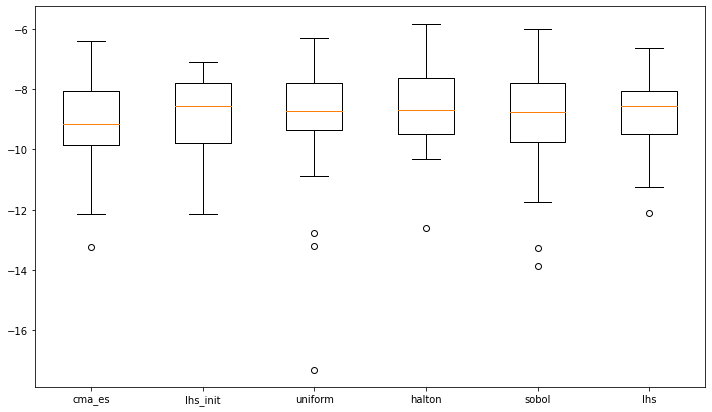

In [21]:
plt.rcParams["figure.figsize"] = (12, 7)

methods = ['cma_es', 'lhs_init', 'uniform', 'halton', 'sobol', 'lhs']
plt.boxplot([np.log(stats[method + '_regret'].div(stats['abs_norm'])) for method in methods])
plt.xticks(list(range(1, len(methods) + 1)), methods)

([<matplotlib.axis.XTick at 0x7f0d1c532d90>,
 [Text(0, 0, 'cma_es'),
  Text(0, 0, 'lhs_init'),
  Text(0, 0, 'uniform'),
  Text(0, 0, 'halton'),
  Text(0, 0, 'sobol'),
  Text(0, 0, 'lhs')])

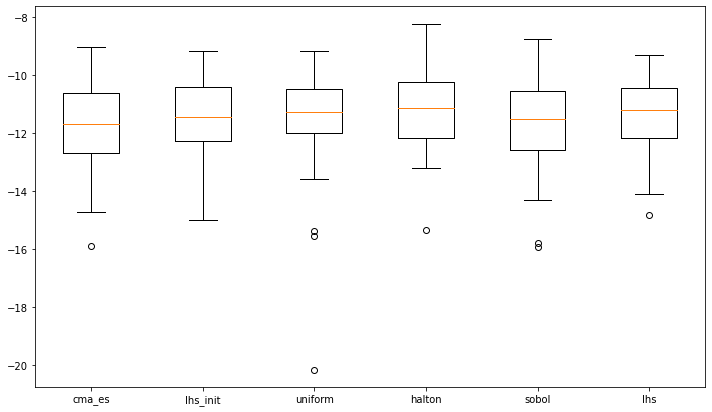

In [22]:
plt.rcParams["figure.figsize"] = (12, 7)

methods = ['cma_es', 'lhs_init', 'uniform', 'halton', 'sobol', 'lhs']
plt.boxplot([np.log(stats[method + '_regret'].div(stats['minmax_norm'])) for method in methods])
plt.xticks(list(range(1, len(methods) + 1)), methods)